<a href="https://colab.research.google.com/github/Frisca-paf/chicken-disease/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
img_size = 256
batch_size = 32

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/ChickenDst",
    shuffle=True,
    image_size = (img_size, img_size),
    batch_size = batch_size
)

Found 4832 files belonging to 8 classes.


In [5]:
class_names = dataset.class_names
class_names

['cocci',
 'healthy',
 'ncd',
 'pcrcocci',
 'pcrhealthy',
 'pcrncd',
 'pcrsalmo',
 'salmo']

In [6]:
len(dataset)

151

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    # print(label_batch.numpy())

[[[168.       187.       191.      ]
  [172.875    193.5      198.3125  ]
  [173.3125   193.625    202.75    ]
  ...
  [169.9375   167.625    157.1875  ]
  [186.625    183.625    176.625   ]
  [107.       104.        97.      ]]

 [[178.5625   197.5625   201.5625  ]
  [170.23438  189.53906  195.01172 ]
  [170.97656  190.78125  199.04297 ]
  ...
  [167.2461   164.375    155.61328 ]
  [134.98047  131.98047  124.98047 ]
  [116.75     113.75     106.75    ]]

 [[183.0625   202.0625   207.4375  ]
  [176.15625  195.15625  201.03906 ]
  [171.85547  191.07031  198.1875  ]
  ...
  [121.03516  117.13281  108.97266 ]
  [102.39453   98.01953   91.70703 ]
  [110.0625   105.6875    99.375   ]]

 ...

 [[ 29.5625    24.1875    24.5     ]
  [ 31.898438  27.082031  25.210938]
  [ 31.835938  27.148438  23.871094]
  ...
  [ 92.765625  91.80859   84.96094 ]
  [124.30078  123.30078  118.42969 ]
  [155.9375   154.9375   150.625   ]]

 [[ 31.875     28.25      29.25    ]
  [ 37.257812  33.785156  33.007812]


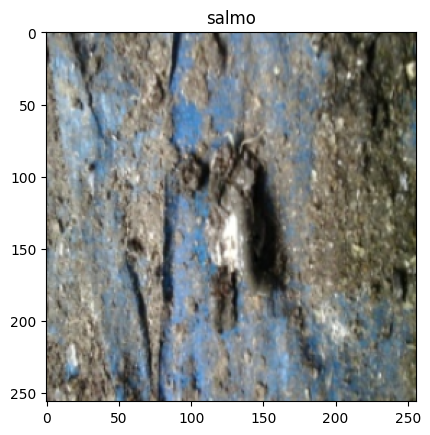

In [8]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

In [9]:
def get_data_partitions(df, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    df_size = len(df)
    if shuffle:
        df = df.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * df_size)
    val_size = int(val_split * df_size)
    
    train_df = df.take(train_size)    
    val_df = df.skip(train_size).take(val_size)
    test_df = df.skip(train_size).skip(val_size)
    
    return train_df, val_df, test_df

In [10]:
train_df, val_df, test_df = get_data_partitions(dataset)

In [11]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_size, img_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [13]:
data_augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
train_df = train_df.map(
    lambda x, y: (data_augment(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

In [15]:
input_shape = (batch_size, img_size, img_size, 3)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(324, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 324)       9072      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 324)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 128)       373376    
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_df,
    batch_size=batch_size,
    validation_data=val_df,
    verbose=1,
    epochs=30,
)

Epoch 1/30
120/120 [==============================] - 94s 527ms/step - loss: 1.5204 - accuracy: 0.4615 - val_loss: 1.3756 - val_accuracy: 0.4833
Epoch 2/30
120/120 [==============================] - 47s 391ms/step - loss: 1.2950 - accuracy: 0.5583 - val_loss: 1.1069 - val_accuracy: 0.5896
Epoch 3/30
120/120 [==============================] - 47s 389ms/step - loss: 1.1079 - accuracy: 0.6242 - val_loss: 1.0377 - val_accuracy: 0.6313
Epoch 4/30
120/120 [==============================] - 48s 400ms/step - loss: 0.9797 - accuracy: 0.6622 - val_loss: 0.9186 - val_accuracy: 0.6708
Epoch 5/30
120/120 [==============================] - 47s 389ms/step - loss: 0.8834 - accuracy: 0.7010 - val_loss: 0.7581 - val_accuracy: 0.7250
Epoch 6/30
120/120 [==============================] - 49s 410ms/step - loss: 0.8324 - accuracy: 0.7193 - val_loss: 0.8148 - val_accuracy: 0.7104
Epoch 7/30
120/120 [==============================] - 49s 409ms/step - loss: 0.7978 - accuracy: 0.7339 - val_loss: 0.7147 - val_ac

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
model.save('chick_diasease_v1.h5')